In [4]:
import pandas as pd

df = pd.read_csv("arabic_enhancement_comparison.csv")

criteria = [
    "Grammatical Correctness: Sentence is well-formed in Fus’ha Arabic, with proper grammar, structure, and syntax.",
    "Word Choice: Uses elevated, expressive Fus’ha vocabulary. High scores go to captions that introduce new, emotionally powerful or poetic words.",
    "Meaning Preservation: The sentence still has the same meaning as the original, even when the style or tone is transformed."
]

rows = []
for idx, row in df.iterrows():
    sample_id = f"Sample {idx + 1}"

    # row 1: artelingo caption
    rows.append({
        "Sample": sample_id,
        "Caption Source": "Artelingo",
        "Caption": row["artelingo_arabic"],
        "Evaluation Criterion": "",
        "Score (1–5)": ""
    })

    # rows 2–4: ALLaM caption with 3 evaluation rows
    for criterion in criteria:
        rows.append({
            "Sample": sample_id,
            "Caption Source": "ALLAM",
            "Caption": row["allam_arabic"],
            "Evaluation Criterion": criterion,
            "Score (1–5)": ""
        })

    # rows 5–7: Hunayn caption with 3 evaluation rows
    for criterion in criteria:
        rows.append({
            "Sample": sample_id,
            "Caption Source": "HUNAYN",
            "Caption": row["hunayn_arabic"],
            "Evaluation Criterion": criterion,
            "Score (1–5)": ""
        })

form_df = pd.DataFrame(rows)
form_df.to_csv("blip_likert_user_study.csv", index=False, encoding="utf-8-sig")

print("blip_likert_user_study.csv created")


blip_likert_user_study.csv created


Went to Google Sheet and imported this CSV file

Then clicked on Extensions then Apps Script

And wrote this code to automate the data loading into 5 Google Forms with every Google Form having a chunk of 20 samples.

The 5 forms were distributed to 5 users for evaluation.

In [ ]:
function createArabicEvaluationForms() {
  const sheet = SpreadsheetApp.getActiveSpreadsheet().getActiveSheet();
  const data = sheet.getDataRange().getValues().slice(1);

  const criteria = [
    "Grammatical Correctness: Sentence is well-formed in Fus’ha Arabic, with proper grammar, structure, and syntax.",
    "Word Choice: Uses elevated, expressive Fus’ha vocabulary. High scores go to captions that introduce new, emotionally powerful or poetic words.",
    "Meaning Preservation: The sentence still has the same meaning as the original, even when the style or tone is transformed."
  ];

  const samplesPerForm = 10;
  const totalSamples = Math.floor(data.length / 7);
  const totalForms = Math.ceil(totalSamples / samplesPerForm);

  let questionNum = 1;

  for (let f = 0; f < totalForms; f++) {
    const form = FormApp.create(`Arabic Caption Evaluation - Part ${f + 1}`);
    const startSample = f * samplesPerForm;
    const endSample = Math.min(startSample + samplesPerForm, totalSamples);

    for (let s = startSample; s < endSample; s++) {
      const base = s * 7;

      const artelingo_caption = data[base][2];

      // === ALLAM caption section ===
      const allam_caption = data[base + 1][2];
      form.addPageBreakItem().setTitle(`Caption ${questionNum}`);
      form.addSectionHeaderItem().setTitle(`Caption ${questionNum}\n${artelingo_caption}\n\n${allam_caption}`);

      for (let i = 0; i < 3; i++) {
        form.addScaleItem()
          .setTitle(criteria[i])
          .setBounds(1, 5)
          .setLabels("1 - Poor", "5 - Excellent")
          .setRequired(true);
      }
      questionNum++;

      // === HUNAYN caption section ===
      const hunayn_caption = data[base + 4][2];
      form.addPageBreakItem().setTitle(`Caption ${questionNum}`);
      form.addSectionHeaderItem().setTitle(`Caption ${questionNum}\n${artelingo_caption}\n\n${hunayn_caption}`);

      for (let i = 0; i < 3; i++) {
        form.addScaleItem()
          .setTitle(criteria[i])
          .setBounds(1, 5)
          .setLabels("1 - Poor", "5 - Excellent")
          .setRequired(true);
      }
      questionNum++;

    }

    Logger.log(`Created Form ${f + 1}: ` + form.getEditUrl());
  }
}

Saved the file to my google drive then ran the script

The responses will come back like this:

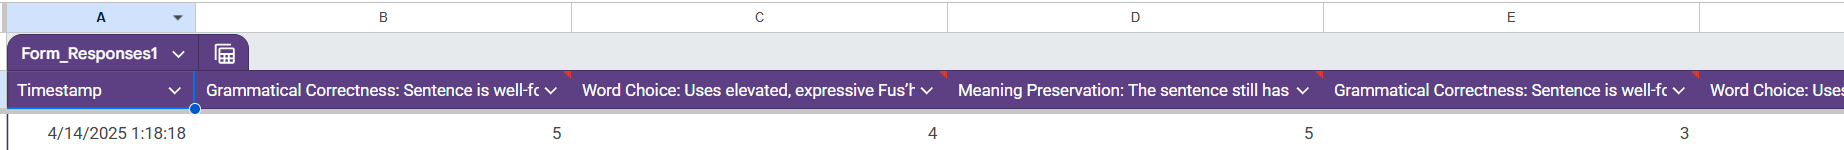

So another Apps Scriptw was written:

In [ ]:
function parseFormResponsesToLongFormat() {
  const sheet = SpreadsheetApp.getActiveSpreadsheet().getSheetByName("Part1Responses"); 
  const data = sheet.getDataRange().getValues();

  const header = data[0].slice(1);
  const rows = data.slice(1);

  const criteria = [
    "Grammatical Correctness",
    "Word Choice",
    "Meaning Preservation"
  ];

  const output = [["Sample", "Model", "Criterion", "Score"]];
  
  rows.forEach((row, rowIndex) => {
    let sampleNum = 1;
    for (let i = 1; i < row.length; i += 6) {
      const allamScores = row.slice(i, i + 3);
      const hunaynScores = row.slice(i + 3, i + 6);

      for (let j = 0; j < 3; j++) {
        output.push([`Sample ${sampleNum}`, "ALLAM", criteria[j], allamScores[j]]);
        output.push([`Sample ${sampleNum}`, "HUNAYN", criteria[j], hunaynScores[j]]);
      }
      sampleNum++;
    }
  });

  const outputSheet = SpreadsheetApp.getActiveSpreadsheet().getSheetByName("Parsed_Scores") || SpreadsheetApp.getActiveSpreadsheet().insertSheet("Parsed_Scores");
  outputSheet.clearContents();
  outputSheet.getRange(1, 1, output.length, 4).setValues(output);

  Logger.log("Parsed data written to 'Parsed_Scores'");
}


To have an excel sheet that looks like this:

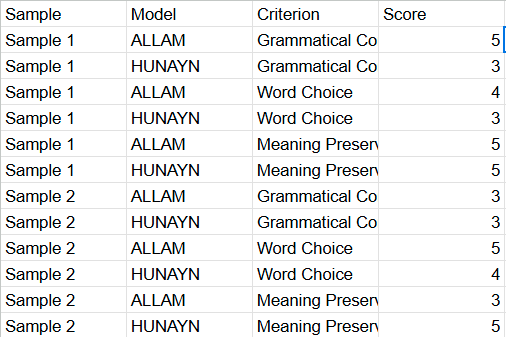

To analyze the results all on one sheet, I merged the 5 excel files into one

In [ ]:
function mergeParsedScoresFromMultipleSpreadsheets() {
  const destination = SpreadsheetApp.getActiveSpreadsheet();
  let outputSheet = destination.getSheetByName("All_Parsed_Scores");
  if (!outputSheet) {
    outputSheet = destination.insertSheet("All_Parsed_Scores");
  } else {
    outputSheet.clearContents();
  }

  const fileIds = [
    "1cdUV7PgAJP38WUjJIu46AG5a_n8jkztStR_O3COlepI",
    "1inYC8Iv_jyNjyaTTg5Ye73I0CTZHsumHw7gHD1tFXbI",
    "1XHEeYbe_NoUQ-htCMy4t78Vw0zaxBM6UZM2mZXpip_Y",
    "1ZTH6udC1pT3aEvpid3aVaI2eMBVbKboxVF-KF_q_5zk",
    "1hd0KyWgB5MrTX5npSNfftBFrwxok5U51xY41zU904Tg"
  ];

  const allData = [["Sample", "Model", "Criterion", "Score"]];
  let sampleCounter = 1;

  for (const id of fileIds) {
    const externalSheet = SpreadsheetApp.openById(id);
    const parsedSheet = externalSheet.getSheetByName("Parsed_Scores");
    if (!parsedSheet) {
      Logger.log(`No 'Parsed_Scores' in: ${id}`);
      continue;
    }

    const data = parsedSheet.getDataRange().getValues();
    for (let i = 1; i < data.length; i += 6) {
      for (let j = 0; j < 6; j++) {
        const row = data[i + j];
        if (row) {
          allData.push([`Sample ${sampleCounter}`, row[1], row[2], row[3]]);
        }
      }
      sampleCounter++;
    }
  }

  outputSheet.getRange(1, 1, allData.length, 4).setValues(allData);
  Logger.log("Merged and reindexed samples written to 'All_Parsed_Scores'");
}


Placed the below excel function and put it next to the first score of the first sample

=IF(B2="ALLAM", IF(D2>D3,"ALLAM", IF(D2<D3,"HUNAYN","TIE")), "")

then dragged it down to dynamically know who won in terms of scores

Results:

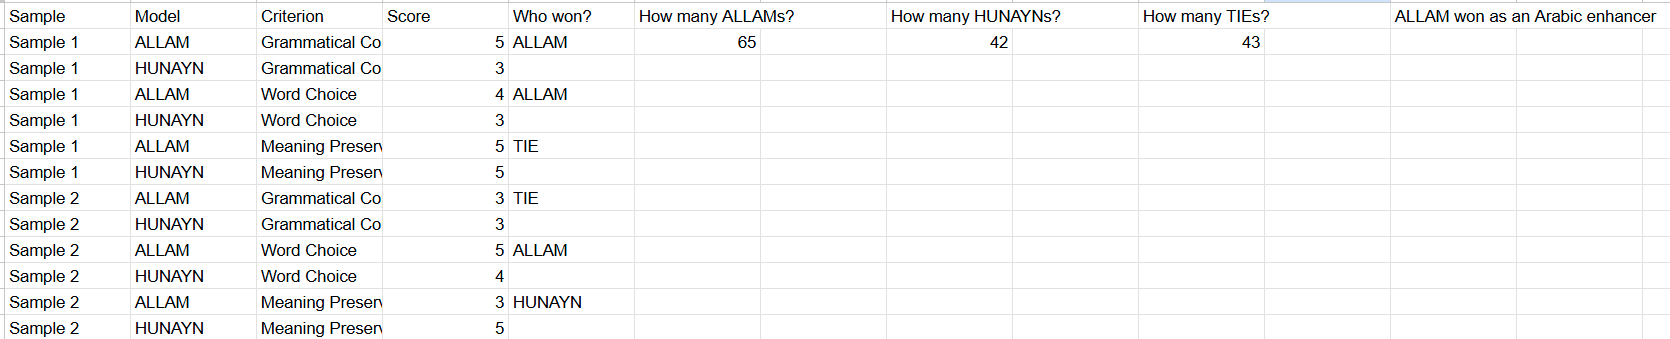

ALLAM will go to phase 3 of the project